In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
def load_qrf():
    actual = pd.read_csv('data/Task 16/train16.csv', parse_dates=['TIMESTAMP'])
    actual = actual[actual['TIMESTAMP'] >= '2013-07-01 01:00'].reset_index(drop=True)
    indices = actual[actual['ZONEID'] == 1]['TIMESTAMP'].reset_index(drop=True)

    prediction_zones1 = pd.concat([pd.read_csv(f'results/{model}/task{task} zone1_neural network.csv')
                         for task in range(4, 16)]).drop(columns='dim_0').rename(columns=lambda x: str((int(x)+1)/100))\
                        .reset_index(drop=True)
    prediction_zones1['TIMESTAMP'] = indices
    prediction_zones1['ZONEID'] = 1

    prediction_zones2 = pd.concat([pd.read_csv(f'results/{model}/task{task} zone2_neural network.csv')
                         for task in range(4, 16)]).drop(columns='dim_0').rename(columns=lambda x: str((int(x)+1)/100))\
                        .reset_index(drop=True)
    prediction_zones2['TIMESTAMP'] = indices
    prediction_zones2['ZONEID'] = 2

    prediction_zones3 = pd.concat([pd.read_csv(f'results/{model}/task{task} zone3_neural network.csv')
                         for task in range(4, 16)]).drop(columns='dim_0').rename(columns=lambda x: str((int(x)+1)/100))\
                        .reset_index(drop=True)
    prediction_zones3['TIMESTAMP'] = indices
    prediction_zones3['ZONEID'] = 3

    prediction = pd.concat([prediction_zones1, prediction_zones2, prediction_zones3])
    prediction.set_index(['TIMESTAMP', 'ZONEID'], inplace=True)
    prediction.sort_index(inplace=True)

    actual = actual.set_index(['TIMESTAMP', 'ZONEID']).sort_index()
    
    return prediction, actual

In [3]:
def load_nnqf():
    actual = pd.read_csv('data/Task 16/train16.csv', parse_dates=['TIMESTAMP'])
    actual = actual[actual['TIMESTAMP'] >= '2013-07-01 01:00'].reset_index(drop=True)
    indices = actual[actual['ZONEID'] == 1]['TIMESTAMP'].reset_index(drop=True)

    prediction_zones1 = pd.concat([pd.read_csv(f'results/{model}/task{task} zone1_prediction.csv', parse_dates=['TIMESTAMP'])
                         for task in range(4, 16)]).reset_index(drop=True)
    prediction_zones1['ZONEID'] = 1

    prediction_zones2 = pd.concat([pd.read_csv(f'results/{model}/task{task} zone2_prediction.csv', parse_dates=['TIMESTAMP'])
                         for task in range(4, 16)]).reset_index(drop=True)
    prediction_zones2['ZONEID'] = 2

    prediction_zones3 = pd.concat([pd.read_csv(f'results/{model}/task{task} zone3_prediction.csv', parse_dates=['TIMESTAMP'])
                         for task in range(4, 16)]).reset_index(drop=True)
    prediction_zones3['ZONEID'] = 3

    prediction = pd.concat([prediction_zones1, prediction_zones2, prediction_zones3])
    prediction.set_index(['TIMESTAMP', 'ZONEID'], inplace=True)
    prediction.sort_index(inplace=True)

    actual = actual.set_index(['TIMESTAMP', 'ZONEID']).sort_index()
    
    return prediction, actual

In [4]:
def load_sqfrnn():
    actual = pd.read_csv('data/Task 16/train16.csv', parse_dates=['TIMESTAMP'])
    actual = actual[actual['TIMESTAMP'] >= '2013-07-01 01:00'].reset_index(drop=True)
    actual = actual.set_index(['TIMESTAMP', 'ZONEID']).sort_index()

    prediction = pd.concat([pd.read_csv(f'results/{model}/task{task}_neural network.csv', parse_dates=['TIMESTAMP'])
                         for task in range(4, 16)]).rename(columns={'ZONE': 'ZONEID'})
    prediction.set_index(['TIMESTAMP', 'ZONEID'], inplace=True)
    prediction.sort_index(inplace=True)
    
    return prediction, actual

In [5]:
# sqf-rnn input

model = 'nnqf'

prediction, actual = load_nnqf()

In [6]:
def sample(quantiles, n):
    ps = np.random.choice(a=[str(p / 100) for p in range(1, 100)], size=n, replace=True)
    xs = quantiles[ps]
    return np.array(xs)[None,...]

sampled = sample(prediction.iloc[0], 20)

In [7]:
from tqdm import tqdm

def energy_score(quantiles, y, n=100):
    """
    Calculates the energy score.
    :param quantiles: np array (99,d)
    :param y: (d,)
    :param n: number of samples
    :return: energy score of the prediction
    """
    xs = np.squeeze(sample(quantiles, n))
    s1 = np.mean(np.linalg.norm(xs - y, axis=0))
    s2 = - 1 / 2 * np.mean(np.linalg.norm(xs[None, ...] - xs[None, ...].T, axis=1))
    return s1 + s2

horizon = 24

scores = []

for zone in range(1, 4):
    pred = prediction.query(f'ZONEID == {zone}')
    act = actual.query(f'ZONEID == {zone}')

    score = np.empty(len(pred) - horizon)
    for i in tqdm(range(len(pred) - horizon)):
        score[i] = energy_score(pred.iloc[i:i+horizon], np.array(act.iloc[i:i+horizon]))

    scores.append(score)

print(f'Energy score: {(scores[0].mean() + scores[1].mean() + scores[2].mean()) / 3}')

100%|██████████| 8736/8736 [00:16<00:00, 524.35it/s]

Energy score: 0.3674566729039969


In [8]:
def cdf(quantiles, x):
    s = x <= quantiles
    if len(s[s==True]) == 0:
        return 0
    return float(s[s==True].index[0])

In [9]:
pits = {hour: [] for hour in range(24)}
for hour in range(24):
    for day in range(len(prediction) // (24 * 3)):
        for task in range(3):
            quantiles = prediction.iloc[hour + (24 * 3) * day + task]
            y = float(actual.iloc[hour + (24 * 3) * day + task])
            pit_value = cdf(quantiles, y)
            if y == 0:
                # if point mass exists, sample from [0, F(y)]
                pits[(hour + 1) % 24].append(np.random.uniform(0, cdf(quantiles, y)))
            else:
                pits[(hour + 1) % 24].append(pit_value)

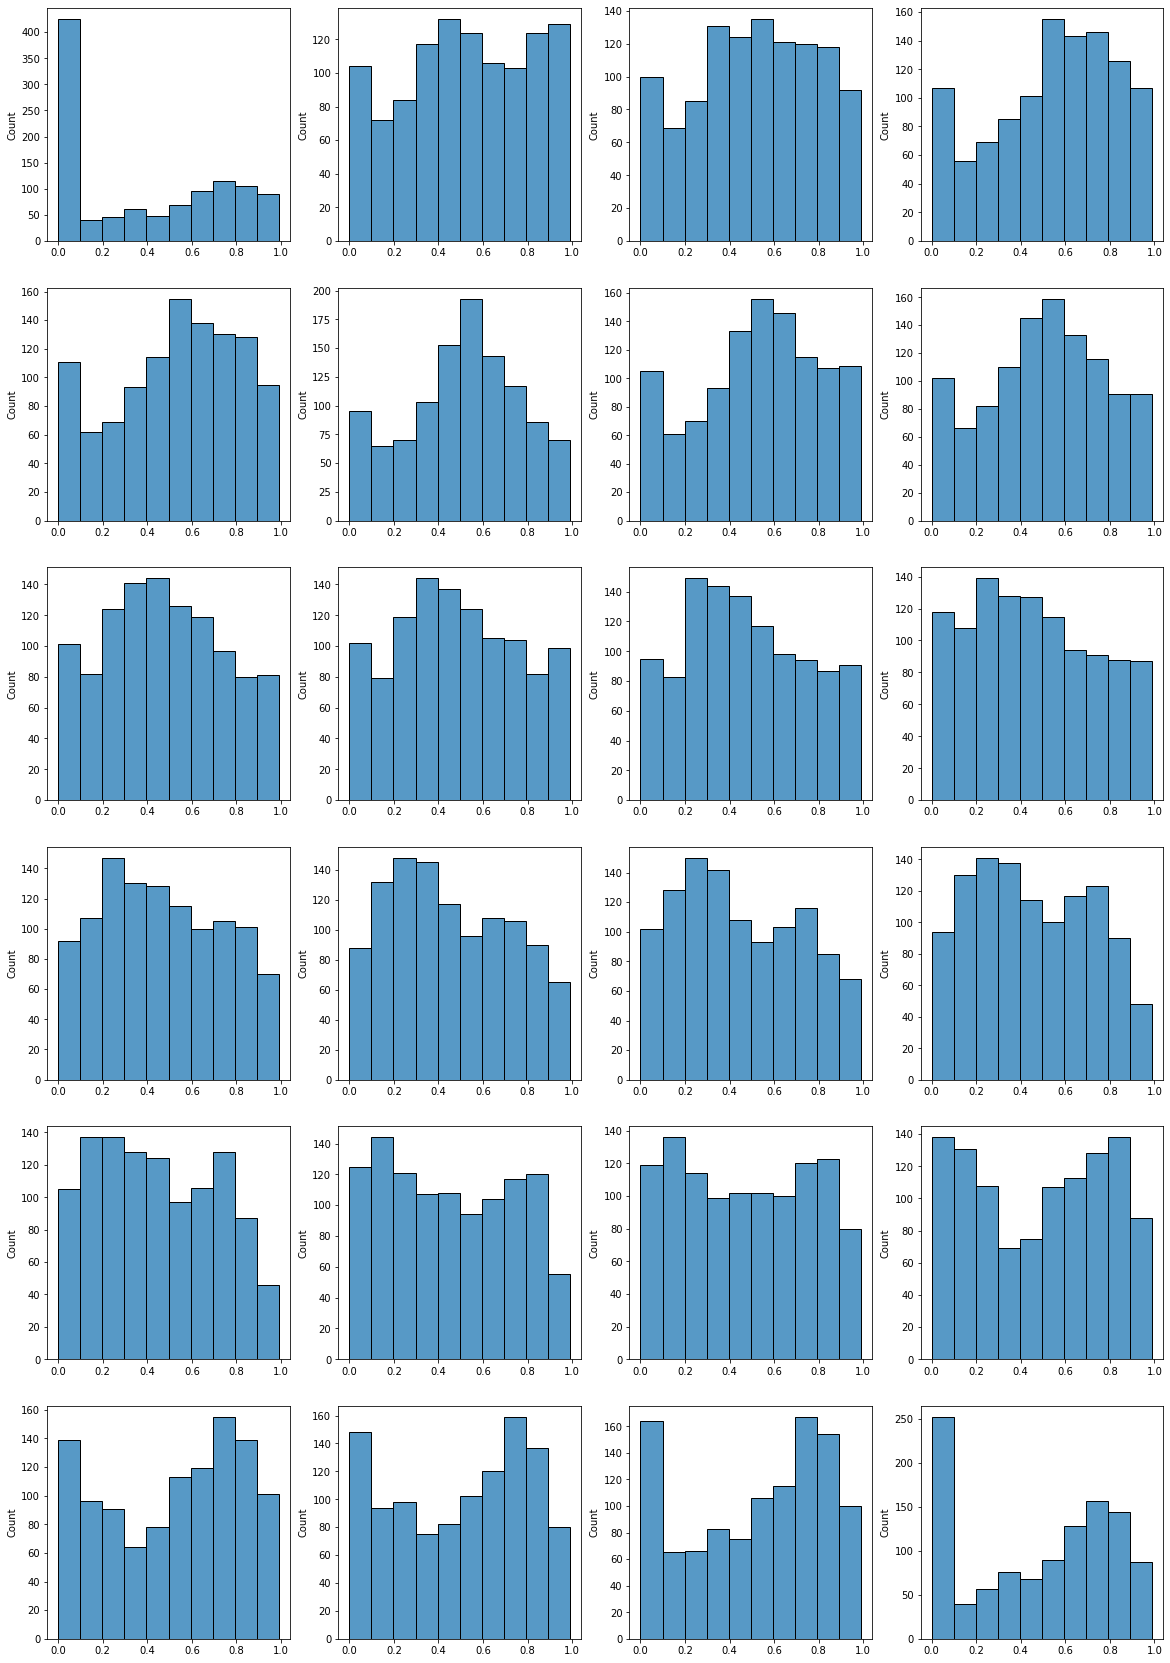

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))

for hour in range(24):
    sns.histplot(data=np.array(pits[hour]), bins=10, ax=axs[hour // 4][hour % 4])

fig.savefig(f'pit_by_hour_{model}.png')

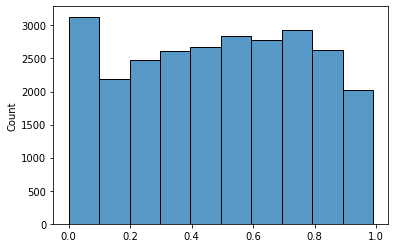

In [11]:
plot = sns.histplot(data=np.array(list(pits.values())).reshape(24*1095), bins=10)
plot.get_figure().savefig(f'pit_{model}.png')